# Introduction

This notebook was made in order to solve the Kaggle competition problem of predicting if a specific person in the titanic was able to survive or not. [See here](https://www.kaggle.com/c/titanic)

In [0]:
!pip install -q missingno

In [2]:
# Upload files to use within collab
from google.colab import files
files = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


# Data preprocessing

In [0]:
# Load the datasets
import pandas as pd
from io import StringIO
df_train = pd.read_csv(StringIO(files['train.csv'].decode('utf-8')))
df_test = pd.read_csv(StringIO(files['test.csv'].decode('utf-8')))


In [4]:
df_train[:1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


## Creating attributes

The **Name** attribute contains the title of a person. It could be used to identify the social status of the deceased ([more here](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/))

In [0]:
import string
def parse_title(name, title_list):
    for title in title_list:
       if title in name:
            return title
    return np.nan
  
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

def replace_titles(x):
    title = x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

df_train['Title'] = df_train['Name'].map(lambda x: parse_title(x, title_list))
df_train['Title'] = df_train.apply(replace_titles, axis=1)

 

The deck now

In [0]:
import numpy as np
def parse_deck(cabin, deck_list):
    if not isinstance(cabin, str):
        return np.nan
    for deck in deck_list:
       if deck in cabin:
            return deck
    return np.nan

cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
df_train['Deck'] = df_train['Cabin'].map(lambda x: parse_deck(x, cabin_list))

More than the amount of siblings and parents o nboard, what matters is the family size

In [0]:
df_train['Family_Size'] = df_train['SibSp'] + df_train['Parch']

In [8]:
df_train[:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NaN,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr,NaN,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,E,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master,NaN,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs,NaN,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs,NaN,1


We drop unused!

In [0]:
df_train = df_train.drop(['Name', 'Cabin', 'SibSp', 'Parch'], axis=1)

## Missing data
At a first glance, we can see that there are many entries with **NaN** attributes. Let's handle them

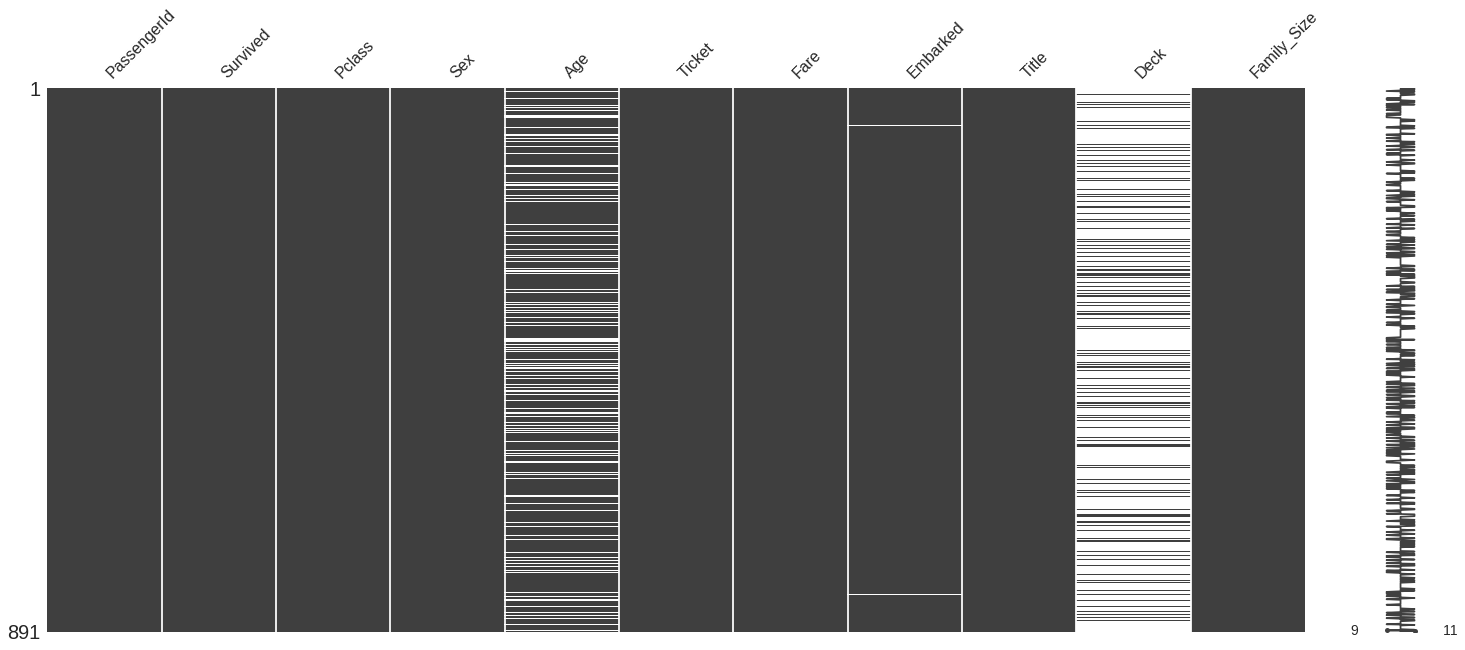

In [10]:
import missingno as msno
msno.matrix(df_train)

We can see there are many many records with missing Deck information, and also with missing age. Let's see how many they are:

In [11]:
total = len(df_train)
with_cabin = len(df_train.dropna(subset=['Deck']))
with_age = len(df_train.dropna(subset=['Age']))

print("%.2f%% of passengers with unknown age" % ((total - with_age) / total * 100.0))
print("%.2f%% of passengers with unknown cabin" % ((total - with_cabin) / total * 100.0))

19.87% of passengers with unknown age
77.10% of passengers with unknown cabin


The best way to handle age is by filling NaN's with the dataset's mean.

In [0]:
# Fill age NaN's with mean.
import numpy as np
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
df_train[['Age']] = imputer.fit_transform(df_train[['Age']])

My guts tell me to simply remove the deck information, but since it gives us spatial information, it is a very good a idea to still consider it. If we assume some decks were high class, then the information provided is very usefull too.

In [0]:
import numpy as np
df_train['Deck'] = df_train['Deck'].replace(np.nan, 'Unknown', regex=True)

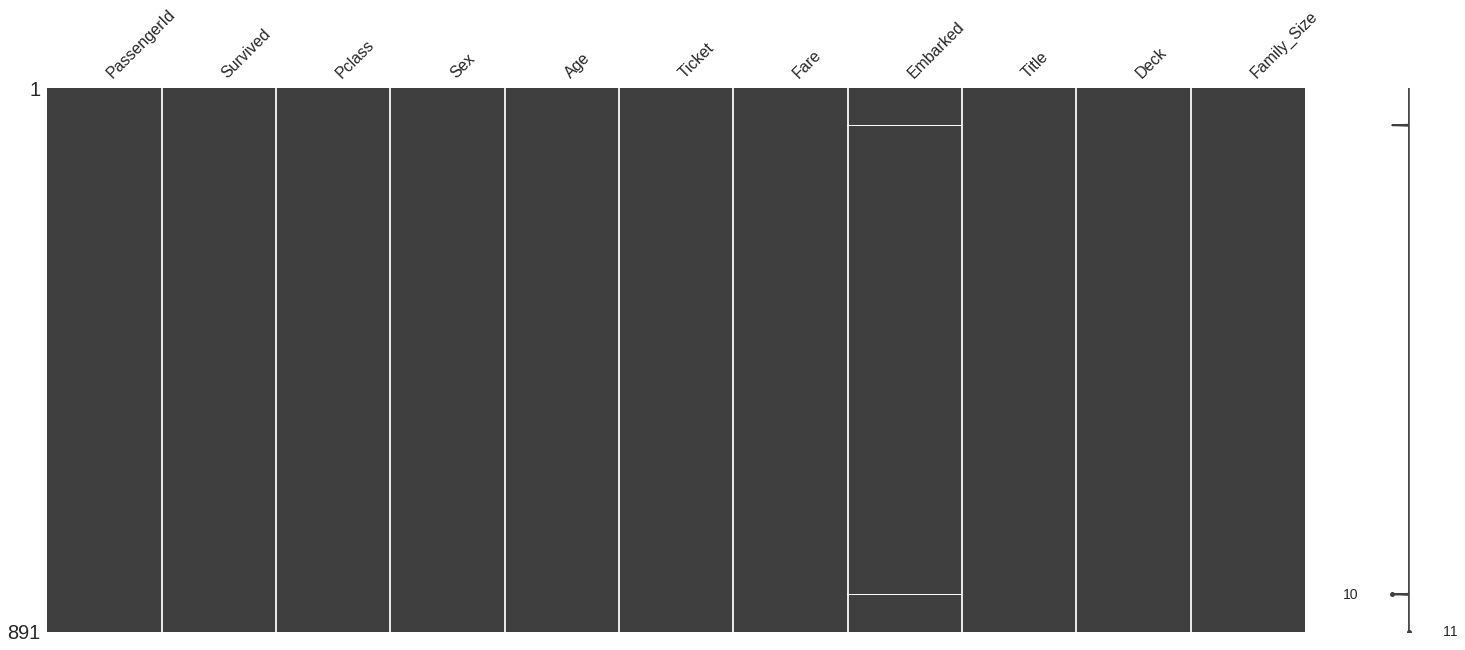

In [14]:
msno.matrix(df_train)

Embarked has still a couple variables with NaN attributes. We should remove them

In [0]:
df_train = df_train.dropna(subset=['Embarked'])

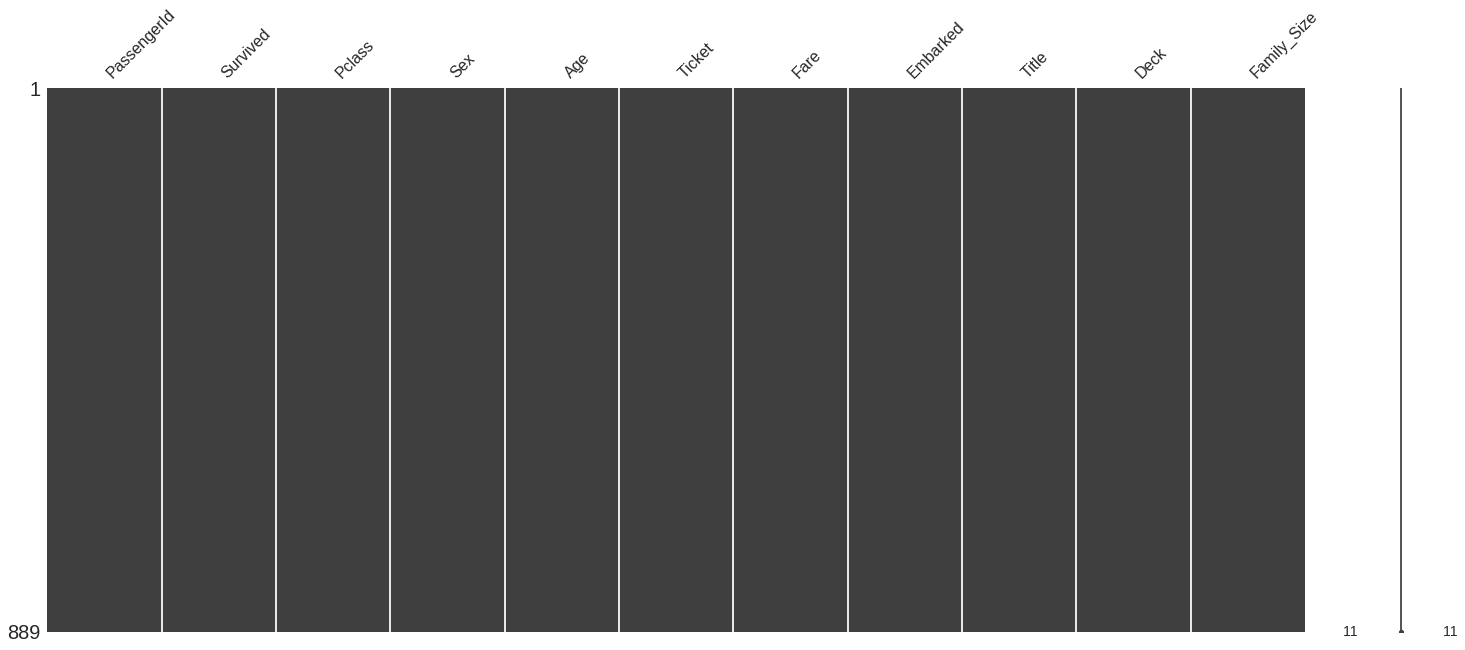

In [16]:
msno.matrix(df_train)

## Useless information

The **Id of the passenger** has absolutely no relation to its survavility.

In [0]:
df_train = df_train.drop(['PassengerId'], axis=1)

## Handling categorical data

Some of the attributes need to be converted into numerical or categorical first so as to the magnitude of their value does not interfere with the learning process. These attributes are **Pclass**, **Sex** and **Embarked**

In [0]:
df_train = pd.concat([df_train, pd.get_dummies(df_train.Sex, prefix='Sex')], axis=1).drop(['Sex'],axis=1)
df_train = pd.concat([df_train, pd.get_dummies(df_train.Pclass, prefix='Pclass')], axis=1).drop(['Pclass'],axis=1)
df_train = pd.concat([df_train, pd.get_dummies(df_train.Embarked, prefix='Embarked')], axis=1).drop(['Embarked'],axis=1)
df_train = pd.concat([df_train, pd.get_dummies(df_train.Deck, prefix='Deck')], axis=1).drop(['Deck'],axis=1)
df_train = pd.concat([df_train, pd.get_dummies(df_train.Title, prefix='Title')], axis=1).drop(['Title'],axis=1)

## Handling the ticket number

Since it can provide information about people travelling together, we will use a dummy_code to work with it.

In [0]:
df_train = df_train.drop(['Ticket'], axis=1)

In [0]:
# df_train = pd.concat([df_train, pd.get_dummies(df_train.Ticket, prefix='Ticket')], axis=1).drop(['Ticket'],axis=1)

In [21]:
df_train.describe()

,Survived,Age,Fare,Family_Size,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Title_Master,Title_Miss,Title_Mr,Title_Mrs
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,...,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,29.315152,32.096681,0.906637,0.350956,0.649044,0.240720,0.206974,0.552306,0.188976,...,0.037120,0.037120,0.013498,0.004499,0.001125,0.772778,0.044994,0.203600,0.597300,0.154106
std,0.486260,12.984932,49.697504,1.614703,0.477538,0.477538,0.427761,0.405365,0.497536,0.391710,...,0.189163,0.189163,0.115460,0.066964,0.033539,0.419273,0.207408,0.402901,0.490717,0.361253
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,28.000000,14.454200,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,35.000000,31.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,80.000000,512.329200,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Training

In order to prevent ouselves from blindly providing answers to Kaggle, let's use a percent of the training data as our validation set

In [0]:
X = df_train[df_train.columns.difference(['Survived'])].values
y = df_train['Survived'].values

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, shuffle=False, test_size=0.25, random_state=30)

## Naive Bayes


### Gaussian

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
model = GaussianNB()
pred_y = model.fit(train_x, train_y).predict(val_x)
print('Validation score %.4f' % accuracy_score(val_y, pred_y))


Validation score 0.8161


In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
model = MultinomialNB()
pred_y = model.fit(train_x, train_y).predict(val_x)
print('Validation score %.4f' % accuracy_score(val_y, pred_y))


Validation score 0.7534


In [26]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
model = BernoulliNB()
pred_y = model.fit(train_x, train_y).predict(val_x)
print('Validation score %.4f' % accuracy_score(val_y, pred_y))


Validation score 0.7982


## SGD

In [27]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
model = linear_model.SGDClassifier(penalty='l1', random_state=42, alpha=0.1)
pred_y = model.fit(train_x, train_y).predict(val_x)
print('Validation score %.4f' % accuracy_score(val_y, pred_y))


Validation score 0.7220


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


## SVM

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
model = SVC()
pred_y = model.fit(train_x, train_y).predict(val_x)
print('Validation score %.4f' % accuracy_score(val_y, pred_y))


Validation score 0.7892


## Random forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier()
pred_y = model.fit(train_x, train_y).predict(val_x)
print('Validation score %.4f' % accuracy_score(val_y, pred_y))


Validation score 0.8341


## Decision tree

In [30]:
from sklearn import tree
from sklearn.metrics import accuracy_score
model = tree.DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
pred_y = model.fit(train_x, train_y).predict(val_x)
print('Validation score %.4f' % accuracy_score(val_y, pred_y))


Validation score 0.7892


# Tests


In [0]:
df_test['Title'] = df_test['Name'].map(lambda x: parse_title(x, title_list))
df_test['Title'] = df_test.apply(replace_titles, axis=1)
df_test['Deck'] = df_test['Cabin'].map(lambda x: parse_deck(x, cabin_list))
df_test['Family_Size'] = df_test['SibSp'] + df_test['Parch']
df_test = df_test.drop(['Name', 'Cabin', 'SibSp', 'Parch'], axis=1)

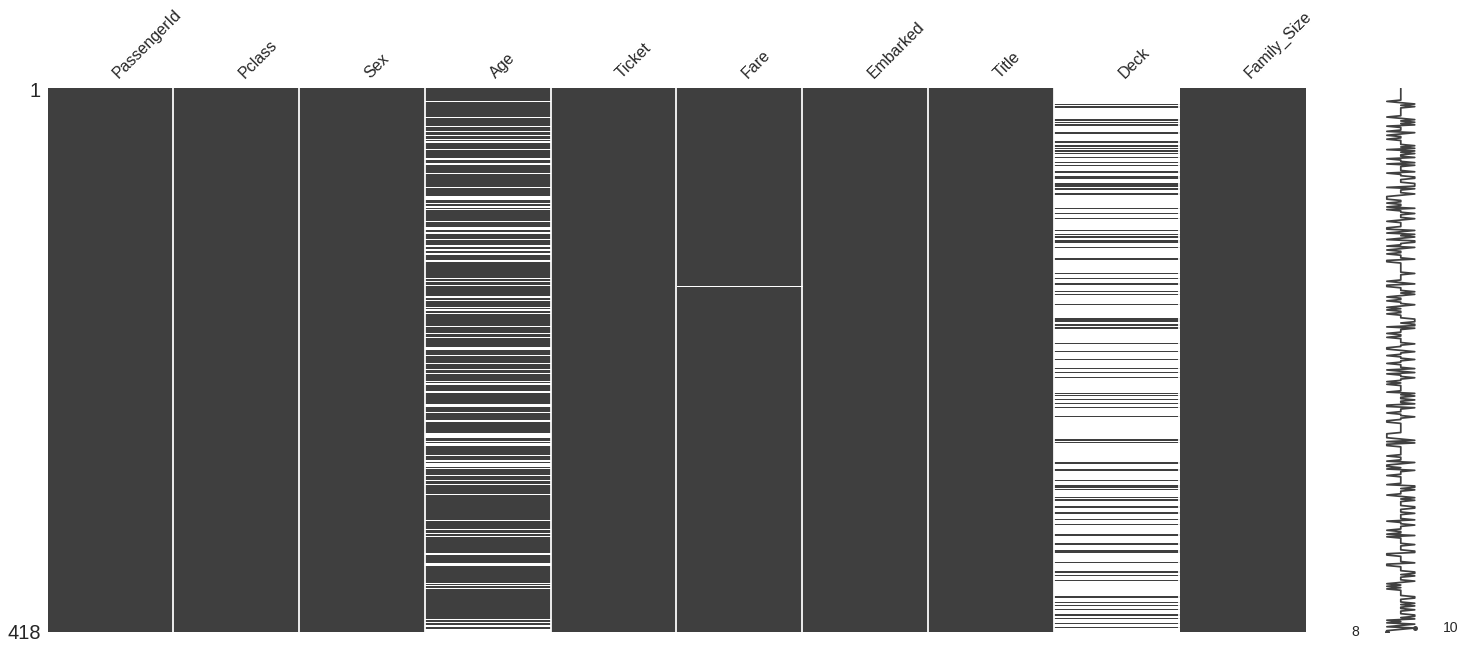

In [32]:
import missingno as msno
msno.matrix(df_test)

In [0]:
# Fill age NaN's with mean.
import numpy as np
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
df_test[['Age']] = imputer.fit_transform(df_test[['Age']])

In [0]:
import numpy as np
df_test['Deck'] = df_test['Deck'].replace(np.nan, 'Unknown', regex=True)

In [0]:
df_test = pd.concat([df_test, pd.get_dummies(df_test.Sex, prefix='Sex')], axis=1).drop(['Sex'],axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test.Pclass, prefix='Pclass')], axis=1).drop(['Pclass'],axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test.Embarked, prefix='Embarked')], axis=1).drop(['Embarked'],axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test.Deck, prefix='Deck')], axis=1).drop(['Deck'],axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test.Title, prefix='Title')], axis=1).drop(['Title'],axis=1)

In [0]:
df_test = df_test.drop(['Ticket'], axis=1)

In [0]:
ids = df_test['PassengerId']
df_test = df_test.drop(['PassengerId'], axis=1)

In [0]:
df_test['Fare'] = df_test['Fare'].replace(np.nan, -1.0, regex=True)

In [0]:
test_x = df_test.values

In [46]:
test_x.shape, X.shape

((418, 23), (889, 24))

In [45]:
print(df_train.columns)
print(df_test.columns)

Index(['Survived', 'Age', 'Fare', 'Family_Size', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Deck_Unknown', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs'],
      dtype='object')
Index(['Age', 'Fare', 'Family_Size', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Deck_Unknown', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs'],
      dtype='object')


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier()
#pred_y = model.fit(X, y).predict(test_x)
